# AACT features with target variable + Adverse Events information + Dropout Reason

## Prep Data for Modeling 

In [1]:
!pip install collinearity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4460 sha256=8fb73376c3063855875fbac8407a65d52c63a0f7258803a2976b2f5ee51d2af2
  Stored in directory: /root/.cache/pip/wheels/31/bf/74/0a475ad9095545c56fe02d678ccd38739baa81513e877d91ca
Successfully built collinearity


In [2]:
# Import necessary packages:

import pandas as pd
import numpy as np
from numpy import mean
from numpy import absolute
from numpy import sqrt
from numpy import std
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn import svm
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns

import scipy.stats as spstats
%matplotlib inline

from collinearity import SelectNonCollinear

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [4]:
# Import necessary packages:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier 
from sklearn import svm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#import AACT files - all diseases
master_disease_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Master Notebooks/master_clean_df.csv", index_col=0)
master_ae_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Master Notebooks/master_ae.csv")
master_dropout_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/master_clean_dropout.csv", index_col=0)

In [7]:
master_dropout_df = master_dropout_df.iloc[:, 0:9]

In [8]:
MIN = 100
MAX = 0
master_disease_df['percent_attrition'].sub(MIN).div(MAX-MIN).clip(0, 1)

0     0.660714
1     0.931818
2     0.960000
3     0.700000
4     0.360710
        ...   
44    0.750000
45    0.483660
46    0.795580
47    0.851528
48    0.500000
Name: percent_attrition, Length: 1359, dtype: float64

Splittarget variable into 4 classifications based on distribution of clinical trial attrition with all neuropsychiatric trials

In [9]:
V4 = pd.merge(master_ae_df, master_disease_df, on='nct_id', how='inner')
V4_df = pd.merge(master_dropout_df, V4, on=['nct_id'], how='inner')

In [10]:
print(V4.shape,V4_df.shape)

(819, 1985) (800, 1994)


In [11]:
Counter(V4_df['disease_type'])

Counter({"Alzheimer's Disease": 193,
         'Amyotrophic lateral sclerosis': 2,
         'Anxiety': 37,
         'Bipolar': 37,
         'Depression': 339,
         "Parkinson's Disease": 192})

In [12]:
#drop nct_id, enrollment_total, drop_count_total, has_expanded_access column 
V4_master_df = V4_df.drop(['nct_id', 'quantile_attrition_range', 'enrollment_total', 'drop_count_total', 'has_expanded_access'], axis = 1)

In [13]:
#convert booleon to binary : has_dmc
V4_master_df.has_dmc = V4_master_df.has_dmc.replace({True: 1, False: 0})
V4_master_df.health_status_eligibility = V4_master_df.health_status_eligibility.replace({'10.0': 0, 'No': 0, 'Accepts Healthy Volunteers' : 1})
#0-does not accept helathy volunteers 1-does accept healthy volunteers
V4_master_df.rename(columns = {'health_status_eligibility':'Accepts_Healthy_volunteers'}, inplace = True)

#one-hot encode categorical colemsn : study_type, study_phase, minimum_age_num, intervention_model_type, allocation_type, masking_type, study_gender_eligibility
prefix_cols = ['study_type',  'study_phase', 'minimum_age_num', 'intervention_model_type', 'allocation_type', 'masking_type', 'study_gender_eligibility']
dummy_cols = ['study_type', 'study_phase', 'minimum_age_num', 'intervention_model_type', 'allocation_type', 'masking_type', 'study_gender_eligibility']

V4_master_df = pd.get_dummies(V4_master_df, prefix=prefix_cols, columns=dummy_cols)

In [14]:
V4_master_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,0,0,1,0,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,0


In [15]:
V4_master_df.isnull().sum().sum()

0

## Depression

### Subset Depression Studies / Split into test and train sets

In [ ]:
V4_depression_df = V4_master_df[V4_master_df['disease_type'] == "Depression"]
V4_depression_df = V4_depression_df.drop(columns=['disease_type', 'intervention_model_type_Sequential Assignment'])

#split into features and outcome dataframes
X_df = V4_depression_df.drop(columns=['percent_attrition'])
y_df = V4_depression_df.percent_attrition

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
5,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
7,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,0.0,...,1,0,1,0,0,0,0,1,0,0
405,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
406,8.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0,10.0,0.0,...,1,0,0,0,1,0,0,1,0,0
407,13.0,0.0,0.0,114.0,7.0,8.0,1.0,0.0,22.0,0.0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
#select all ae columns
ae_df = X_df.iloc[:,9:1962]

#replace all non zero cells with 1
ae_df[ae_df != 0] = 1

#add all columns and select the top ten most prevelant
s = ae_df.sum()
top_ae_table = ae_df[s.sort_values(ascending=False).index[:10]]

#generated list of most prevelant ae
top_ae_table_list = list(top_ae_table.columns)

In [ ]:
X_df.shape

(339, 2010)

In [ ]:
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
5,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
7,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,0.0,...,1,0,1,0,0,0,0,1,0,0
405,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
406,8.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0,10.0,0.0,...,1,0,0,0,1,0,0,1,0,0
407,13.0,0.0,0.0,114.0,7.0,8.0,1.0,0.0,22.0,0.0,...,0,0,1,0,0,0,0,1,0,0


### Colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
5,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
7,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,0.0,...,1,0,1,0,0,0,0,1,0,0
405,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
406,8.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0,10.0,0.0,...,1,0,0,0,1,0,0,1,0,0
407,13.0,0.0,0.0,114.0,7.0,8.0,1.0,0.0,22.0,0.0,...,0,0,1,0,0,0,0,1,0,0


### Corelated Feature Drop

In [ ]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
dropout_reason_adverse event,1.000000,0.236928,0.050688,0.592236,0.569987,0.663702,0.227710,0.681694,0.673219,-0.057171,...,-0.003499,-0.044567,0.003703,-0.056593,0.040543,-0.117357,0.074695,0.093445,-0.074829,-0.058233
dropout_reason_consent withdrawn,0.236928,1.000000,-0.033768,0.030314,0.045809,0.216796,-0.057828,0.290410,-0.108052,-0.024285,...,-0.038401,0.046037,0.001759,-0.024735,-0.046656,-0.050382,0.043163,0.061071,-0.055159,-0.024735
dropout_reason_death,0.050688,-0.033768,1.000000,0.056496,0.104402,0.166846,0.000384,-0.035764,0.165816,-0.016003,...,0.035980,-0.058782,0.089205,-0.016300,-0.031071,0.057242,-0.038576,0.031771,-0.027084,-0.016300
dropout_reason_inclusion/exclusion criteria issue,0.592236,0.030314,0.056496,1.000000,0.418130,0.429081,0.081411,0.355182,0.402866,-0.032966,...,-0.094862,-0.012105,0.073121,-0.033578,0.001313,-0.053890,-0.038335,0.064637,-0.054907,-0.033578
dropout_reason_lack of efficacy,0.569987,0.045809,0.104402,0.418130,1.000000,0.365045,0.087598,0.243812,0.386981,-0.027997,...,0.017603,0.013323,0.047799,-0.029400,0.015803,-0.059881,-0.048964,0.052537,-0.043639,-0.029400


In [ ]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,1,0,0,0,1,0,1,0,0
5,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
7,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,0.0,...,0,1,0,1,0,0,0,1,0,0
405,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,0,0
406,8.0,0.0,0.0,3.0,1.0,2.0,0.0,4.0,10.0,0.0,...,0,1,0,0,1,0,0,1,0,0
407,13.0,0.0,0.0,114.0,7.0,8.0,1.0,0.0,22.0,0.0,...,1,0,0,1,0,0,0,1,0,0


Standardize and split data 

In [ ]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((271, 334), (68, 334))

In [ ]:
res_min = min(y_train,key=lambda x:float(x))
res_max = max(y_train,key=lambda x:float(x))

In [ ]:
print("The min value of list : " + str(res_min))
print("The max value of list : " + str(res_max))

The min value of list : 1.4492753623188406
The max value of list : 92.0


In [ ]:
res_min = min(y_test,key=lambda x:float(x))
res_max = max(y_test,key=lambda x:float(x))

In [ ]:
print("The min value of list : " + str(res_min))
print("The max value of list : " + str(res_max))

The min value of list : 1.1904761904761905
The max value of list : 85.16209476309227


In [ ]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)

0.4288759363250807

In [ ]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
dropout_reason_inclusion/exclusion criteria issue,0.318439
dropout_reason_lost to follow-up,0.058545
event_type_other,0.045327
Headache,0.040401
study_duration_months,0.038388
Abdominal pain,0.037683
intervention_model_type_Factorial Assignment,0.037326
Genetic,0.034936
Nausea,0.028028
dropout_reason_adverse event,0.025854


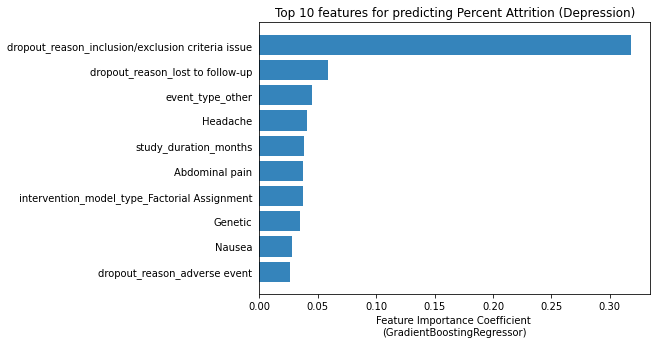

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Depression)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('depression_important_features.png')

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

Linear Regression Train R_Square: 0.9607516056340548
Linear Regression Best Params: {'fit_intercept': False}
Linear Regression Test R_Square: -4814.08906445563
Linear Regression Best Params: {'fit_intercept': False}
Support Vector Regressor Train R_Square: 0.8781396760001204
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Support Vector Regressor Test R_Square: 0.22279475016857464
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Random Forest Regressor Train R_Square: 0.7938551534851068
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Random Forest Regressor Test R_Square: 0.4450837305239228
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Decision Tree Regressor Train R_Square: 0.3798043439292259
Decision Tree Regressor Best Params: {'criterion': 'absolute_error', 'max_depth': 6, 'max_leaf

[0.0, 100.0]

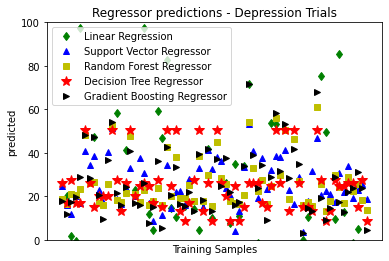

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Depression Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Anxiety 

### Subset Anxiety Studies / Split into test and train sets

In [ ]:
V4_anxiety_df = V4_master_df[V4_master_df['disease_type'] == "Anxiety"]
V4_anxiety_df = V4_anxiety_df.drop(columns=['disease_type', 'intervention_model_type_Sequential Assignment'])

#split into features and outcome dataframes
X_df = V4_anxiety_df.drop(columns=['percent_attrition'])
y_df = V4_anxiety_df.percent_attrition

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
27,0.0,0.0,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,...,1,1,0,0,0,0,0,1,0,0
29,0.0,0.0,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,...,1,1,0,0,0,0,0,1,0,0
92,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1,0,0,0,1,0,0,1,0,0
94,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1,0,0,0,1,0,0,1,0,0
111,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,...,1,0,0,0,0,0,1,0,1,0
113,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,...,1,0,0,0,0,0,1,0,1,0
125,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
127,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
132,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,...,0,0,1,0,0,0,0,1,0,0
134,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
#drop all columns that contain only zeros
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,Rash,Somnolence,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
27,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,0
29,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,0
92,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
94,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
111,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
113,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
125,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
127,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
132,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,...,0,0,0,1,0,0,0,1,0,0
134,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,...,0,0,0,1,0,0,0,1,0,0


### Colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,Rash,Somnolence,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
27,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,0
29,0.0,22.0,0.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,0
92,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
94,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,...,0,1,0,0,1,0,0,1,0,0
111,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
113,0.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
125,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
127,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,1,0
132,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,...,0,0,0,1,0,0,0,1,0,0
134,0.0,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,...,0,0,0,1,0,0,0,1,0,0


### Corelated Feature Drop

In [ ]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,Rash,Somnolence,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
dropout_reason_adverse event,1.000000,0.003749,0.915385,0.023230,-0.004886,0.054918,0.044829,-0.085009,0.003439,-0.046529,...,-0.085009,0.123810,-0.156451,-0.114503,-0.038475,-0.085009,0.437329,0.090796,-0.049253,-0.085009
dropout_reason_inclusion/exclusion criteria issue,0.003749,1.000000,0.059922,-0.037710,-0.177832,-0.159981,0.407365,-0.134886,-0.099965,-0.178894,...,-0.090720,0.164290,0.347835,-0.172532,-0.096031,-0.134886,0.083692,-0.091795,0.185268,-0.134886
dropout_reason_lack of efficacy,0.915385,0.059922,1.000000,0.082819,0.082437,-0.054967,0.062360,-0.039841,-0.058026,-0.052840,...,-0.039841,0.058026,-0.073324,-0.130032,-0.101430,-0.039841,0.421637,0.087538,-0.073324,-0.039841
dropout_reason_lost to follow-up,0.023230,-0.037710,0.082819,1.000000,-0.148120,-0.171632,-0.213275,0.134261,-0.176355,-0.170855,...,-0.082397,0.153815,-0.161138,0.524785,-0.288571,-0.113348,-0.120897,0.240546,-0.189620,-0.128824
dropout_reason_physician decision,-0.004886,-0.177832,0.082437,-0.148120,1.000000,-0.095545,0.091041,-0.100501,-0.146374,0.281143,...,-0.100501,-0.172204,0.418887,-0.124038,-0.200175,-0.100501,0.050834,0.040592,0.016320,-0.100501


In [ ]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,Rash,Somnolence,Nausea,...,intervention_model_type_Crossover Assignment,intervention_model_type_Parallel Assignment,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female
27,0.0,22.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,60.0,...,0,1,1,1,0,0,0,0,1,0
29,0.0,22.0,5.0,0.0,0.0,14.0,0.0,0.0,0.0,60.0,...,0,1,1,1,0,0,0,0,1,0
92,0.0,3.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,...,1,0,1,0,0,1,0,0,1,0
94,0.0,3.0,1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,...,1,0,1,0,0,1,0,0,1,0
111,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,1
113,0.0,0.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,1
125,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,1
127,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,1,0,1
132,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,0.0,...,0,1,0,0,1,0,0,0,1,0
134,0.0,0.0,0.0,4.0,0.0,15.0,0.0,0.0,20.0,0.0,...,0,1,0,0,1,0,0,0,1,0


Standardize and split data 

In [ ]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [ ]:
X_df_norm.isnull().sum()

dropout_reason_adverse event                          0
dropout_reason_inclusion/exclusion criteria issue     0
dropout_reason_lost to follow-up                      0
dropout_reason_physician decision                     0
dropout_reason_protocol violation                     0
dropout_reason_subject withdrawal                     0
Influenza                                             0
Rash                                                  0
Somnolence                                            0
Nausea                                                0
Fatigue                                               0
Seizure                                               0
Dysuria                                               0
Headache                                              0
Pain in jaw                                           0
Aphasia                                               0
Feeling abnormal                                      0
Musculoskeletal stiffness                       

In [ ]:
X_df_norm.columns.to_series()[np.isinf(X_df_norm).any()]

Series([], dtype: object)

In [ ]:
X_df_norm['study_type_Interventional'] = X_df_norm['study_type_Interventional'].fillna(0)

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((29, 51), (8, 51))

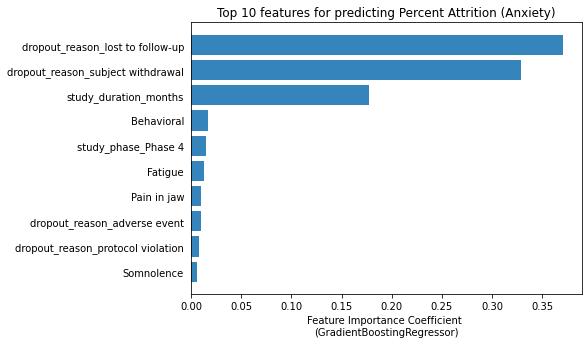

In [ ]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Anxiety)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('anxiety_important_features.png')

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

Linear Regression Train R_Square: 1.0
Linear Regression Best Params: {'fit_intercept': False}
Linear Regression Test R_Square: 1.0
Linear Regression Best Params: {'fit_intercept': False}
Support Vector Regressor Train R_Square: 0.9999999996813229
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 0, 'gamma': 1.0, 'kernel': 'rbf'}
Support Vector Regressor Test R_Square: 0.9999999995638257
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 0, 'gamma': 1.0, 'kernel': 'rbf'}
Random Forest Regressor Train R_Square: 0.9445400717669397
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 150}
Random Forest Regressor Test R_Square: 0.815172430863095
Random Forest Regressor Best Params: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}
Decision Tree Regressor Train R_Square: 0.0
Decision Tree Regressor Best Params: {'criterion': 'squared_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 20, 'min_samples_sp

[0.0, 100.0]

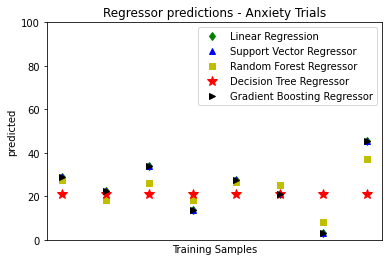

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Anxiety Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Bipolar

### Subset Bipolar Studies / Split into test and train sets

In [18]:
V4_bipolar_df = V4_master_df[V4_master_df['disease_type'] == "Bipolar"]
V4_bipolar_df = V4_bipolar_df.drop(columns=['disease_type', 'intervention_model_type_Sequential Assignment'])

#split into features and outcome dataframes
X_df = V4_bipolar_df.drop(columns=['percent_attrition'])
y_df = V4_bipolar_df.percent_attrition

In [19]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((29, 2010), (8, 2010))

In [20]:
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Rash,Pain,...,intervention_model_type_Parallel Assignment,intervention_model_type_Single Group Assignment,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Triple,study_gender_eligibility_All
37,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
39,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
54,6.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
56,12.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
65,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
67,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
170,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
172,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1


### Colinearity

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [22]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Rash,Pain,...,intervention_model_type_Parallel Assignment,intervention_model_type_Single Group Assignment,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Triple,study_gender_eligibility_All
37,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
39,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
54,6.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
56,12.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
65,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
67,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
170,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
172,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1


### Corelated Feature Drop

In [23]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Rash,Pain,...,intervention_model_type_Parallel Assignment,intervention_model_type_Single Group Assignment,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Triple,study_gender_eligibility_All
dropout_reason_adverse event,1.000000,0.293471,0.863580,0.886992,0.536462,0.171939,0.848965,0.701763,-0.116910,-0.133233,...,0.027384,0.071150,-0.092892,0.182991,-0.142866,-0.101549,0.105856,0.086947,-0.126722,NaN
dropout_reason_consent withdrawn,0.293471,1.000000,0.372603,0.261720,0.410323,-0.119617,0.190506,-0.163261,-0.083081,-0.083081,...,0.240793,-0.197045,-0.057926,-0.197045,0.211515,-0.137383,-0.226065,0.501652,-0.197045,NaN
dropout_reason_inclusion/exclusion criteria issue,0.863580,0.372603,1.000000,0.664121,0.487182,0.248795,0.638815,0.583045,-0.005616,-0.161451,...,0.072732,0.020903,-0.112566,0.192012,-0.144398,-0.198257,0.100363,0.027635,0.020903,NaN
dropout_reason_lack of efficacy,0.886992,0.261720,0.664121,1.000000,0.457765,-0.005027,0.880176,0.606561,-0.130905,-0.130905,...,0.025506,0.064935,-0.091269,0.075660,-0.039768,-0.054934,0.006259,0.141610,-0.117404,NaN
dropout_reason_lost to follow-up,0.536462,0.410323,0.487182,0.457765,1.000000,0.234654,0.542978,0.498929,-0.172239,-0.046872,...,0.277149,-0.177240,-0.018112,-0.045091,0.050176,-0.160429,-0.091358,0.343572,-0.149709,NaN


In [24]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [25]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Rash,Pain,...,intervention_model_type_Parallel Assignment,intervention_model_type_Single Group Assignment,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Triple,study_gender_eligibility_All
37,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
39,1.0,0.0,0.0,0.0,33.0,0.0,0.0,9.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,1
54,6.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
56,12.0,0.0,0.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,1,0,0,0,1
65,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
67,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
170,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1
172,0.0,0.0,6.0,0.0,19.0,0.0,1.0,11.0,0.0,0.0,...,1,0,0,0,1,0,0,0,1,1


Standardize and split data 

In [26]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [27]:
X_df_norm.columns.to_series()[np.isinf(X_df_norm).any()]

Series([], dtype: object)

In [28]:
X_df_norm.isnull().sum()

dropout_reason_adverse event                          0
dropout_reason_consent withdrawn                      0
dropout_reason_inclusion/exclusion criteria issue     0
dropout_reason_lack of efficacy                       0
dropout_reason_lost to follow-up                      0
                                                     ..
masking_type_Double                                   0
masking_type_None (Open Label)                        0
masking_type_Quadruple                                0
masking_type_Triple                                   0
study_gender_eligibility_All                         37
Length: 61, dtype: int64

In [29]:
X_df_norm = X_df_norm.fillna(0)

In [30]:
count = np.isnan(X_df_norm).values.sum()

In [31]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((29, 61), (8, 61))

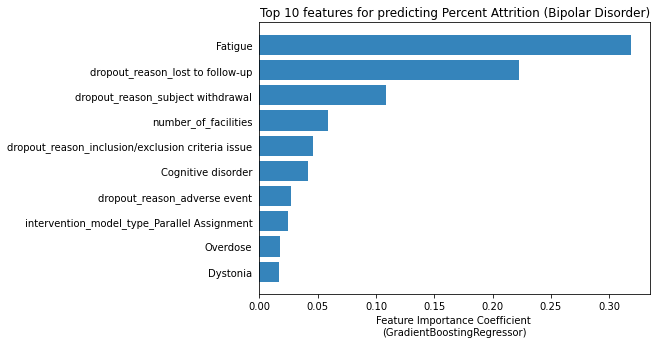

In [32]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Bipolar Disorder)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('bipolar_important_features.png')

In [33]:
mean(y_df)

30.43135113148484

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

Linear Regression Train R_Square: 1.0
Linear Regression Best Params: {'fit_intercept': False}
Linear Regression Test R_Square: 0.8182512090926389
Linear Regression Best Params: {'fit_intercept': False}
Support Vector Regressor Train R_Square: -0.02485906736224619
Support Vector Regressor Best Params: {'C': 1.0, 'epsilon': 0, 'gamma': 1.0, 'kernel': 'rbf'}
Support Vector Regressor Test R_Square: -0.08414706988229215
Support Vector Regressor Best Params: {'C': 1.0, 'epsilon': 0, 'gamma': 1.0, 'kernel': 'rbf'}
Random Forest Regressor Train R_Square: 0.8764838995161431
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 100}
Random Forest Regressor Test R_Square: 0.6522866186999969
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 50}
Decision Tree Regressor Train R_Square: -0.12550726245469446
Decision Tree Regressor Best Params: {'criterion': 'absolute_error', 'max_depth': 2, 'max_leaf_nodes': 5, 'min_s

[0.0, 100.0]

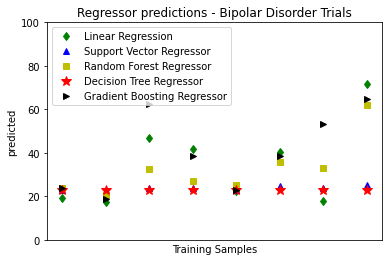

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Bipolar Disorder Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Alzheimer's Disease

### Subset Alzheimer's Disease Studies / Split into test and train sets

In [34]:
V4_alzheimers_df = V4_master_df[V4_master_df['disease_type'] == "Alzheimer's Disease"]
V4_alzheimers_df = V4_alzheimers_df.drop(columns=['disease_type', 'intervention_model_type_Sequential Assignment'])

#split into features and outcome dataframes
X_df = V4_alzheimers_df.drop(columns=['percent_attrition'])
y_df = V4_alzheimers_df.percent_attrition

In [35]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((154, 2010), (39, 2010))

In [36]:
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
269,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
271,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
316,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
318,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
325,0.0,0.0,1.0,26.0,0.0,24.0,0.0,0.0,21.0,0.0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,1,0,0,0,0,1,0
612,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,0,1,1,0,0,0,0,0,0,1
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,1,0
614,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,7.0,0.0,...,0,0,0,1,0,0,0,0,1,0


### Colinearity

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [38]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
269,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
271,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
316,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
318,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,1,0,0,1,0,0,0,0,1,0
325,0.0,0.0,1.0,26.0,0.0,24.0,0.0,0.0,21.0,0.0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,1,0,0,0,0,1,0
612,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,0,1,1,0,0,0,0,0,0,1
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,1,0
614,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,7.0,0.0,...,0,0,0,1,0,0,0,0,1,0


### Corelated Feature Drop

In [39]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
dropout_reason_adverse event,1.000000,0.237846,0.298972,0.565721,0.197587,0.224658,0.240606,0.589975,0.588069,0.003276,...,-0.080608,0.123205,-0.044521,-0.081317,-0.014257,0.137459,-0.103984,0.033563,0.036087,-0.036087
dropout_reason_consent withdrawn,0.237846,1.000000,0.138402,0.370100,0.080904,0.055113,-0.012491,0.065628,0.000652,-0.007568,...,-0.062143,0.090372,0.030074,-0.085003,-0.023521,0.138742,-0.033621,-0.075278,0.011668,-0.011668
dropout_reason_death,0.298972,0.138402,1.000000,0.181400,0.086247,0.162898,0.227897,0.138321,0.464115,0.069795,...,-0.012952,0.067144,-0.061548,0.006551,-0.018748,0.111885,-0.035637,-0.050367,0.020343,-0.020343
dropout_reason_inclusion/exclusion criteria issue,0.565721,0.370100,0.181400,1.000000,0.163769,0.202686,0.025720,0.089250,0.409613,0.056653,...,-0.054126,0.086368,-0.055511,-0.065199,-0.033962,0.139876,-0.049354,0.003190,0.021433,-0.021433
dropout_reason_lack of efficacy,0.197587,0.080904,0.086247,0.163769,1.000000,0.046159,-0.012844,-0.007926,0.128763,-0.001321,...,0.086281,-0.060349,-0.033337,0.077214,-0.009485,0.030435,-0.042828,-0.062107,0.014863,-0.014863


In [40]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [41]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
269,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,0,1,0,0,1,0,0,0,1,0
271,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,5.0,0.0,...,0,1,0,0,1,0,0,0,1,0
316,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,0,1,0,0,1,0,0,0,1,0
318,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,...,0,1,0,0,1,0,0,0,1,0
325,0.0,0.0,1.0,26.0,0.0,24.0,0.0,0.0,21.0,0.0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1,0,0,0,1,0,0,0,1,0
612,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,0,0,1,1,0,0,0,0,0,1
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,1,0,0,1,0
614,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,7.0,0.0,...,1,0,0,0,1,0,0,0,1,0


Standardize and split data 

In [42]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [43]:
X_df_norm.columns.to_series()[np.isinf(X_df_norm).any()]

Series([], dtype: object)

In [44]:
X_df_norm.isnull().sum()

dropout_reason_adverse event                         0
dropout_reason_consent withdrawn                     0
dropout_reason_death                                 0
dropout_reason_inclusion/exclusion criteria issue    0
dropout_reason_lack of efficacy                      0
                                                    ..
masking_type_Quadruple                               0
masking_type_Single                                  0
masking_type_Triple                                  0
study_gender_eligibility_All                         0
study_gender_eligibility_Male                        0
Length: 555, dtype: int64

In [45]:
X_df_norm['study_gender_eligibility_All'] = X_df_norm['study_gender_eligibility_All'].fillna(0)

In [46]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((154, 555), (39, 555))

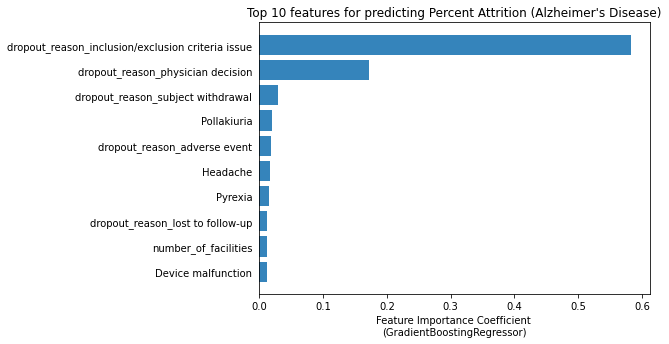

In [47]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Alzheimer's Disease)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('alzheimers_important_features.png')

In [48]:
mean(y_df)

30.890330802202524

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

Linear Regression Train R_Square: 1.0
Linear Regression Best Params: {'fit_intercept': False}
Linear Regression Test R_Square: -7.056466560969881
Linear Regression Best Params: {'fit_intercept': False}
Support Vector Regressor Train R_Square: 0.9232165069503946
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 5, 'gamma': 0.1, 'kernel': 'rbf'}
Support Vector Regressor Test R_Square: 0.5364312780786276
Support Vector Regressor Best Params: {'C': 100.0, 'epsilon': 5, 'gamma': 0.1, 'kernel': 'rbf'}
Random Forest Regressor Train R_Square: 0.9496402838883617
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 1000}
Random Forest Regressor Test R_Square: 0.6924132039138842
Random Forest Regressor Best Params: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}
Decision Tree Regressor Train R_Square: 0.6168035915292035
Decision Tree Regressor Best Params: {'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 5, 'min_sam

[0.0, 100.0]

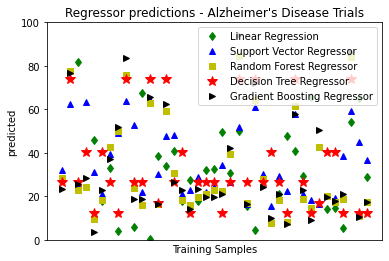

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Alzheimer's Disease Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Parkinson's Disease

### Subset Parkinson's Disease Studies / Split into test and train sets

In [ ]:
V4_parkinsons_df = V4_master_df[V4_master_df['disease_type'] == "Parkinson's Disease"]
V4_parkinsons_df = V4_parkinsons_df.drop(columns=['disease_type', 'intervention_model_type_Sequential Assignment'])

#split into features and outcome dataframes
X_df = V4_parkinsons_df.drop(columns=['percent_attrition'])
y_df = V4_parkinsons_df.percent_attrition

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((153, 2010), (39, 2010))

In [ ]:
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Pain,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,1,0,0,0,0,0,1,1,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,1,0,0,0,0,0,1,1,0
6,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,0,1,0,0,1,0
8,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,0,1,0,0,1,0
23,26.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,6.0,0.0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,1,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,1,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,0,1,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0


### Colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Pain,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,1,0,0,0,0,0,1,1,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,1,0,0,0,0,0,1,1,0
6,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,0,1,0,0,1,0
8,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,1,0,0,0,1,0,0,1,0
23,26.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,6.0,0.0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,1,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,1,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,0,1,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,1,0


### Corelated Feature Drop

In [ ]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Pain,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Male
dropout_reason_adverse event,1.000000,0.247704,0.172140,0.292774,0.565511,0.519460,0.116031,0.444213,0.406372,-0.045369,...,0.025324,-0.110175,-0.028622,0.010587,0.217556,-0.036255,-0.114037,-0.042283,-0.177064,0.177064
dropout_reason_consent withdrawn,0.247704,1.000000,-0.019762,0.658540,0.374822,0.024945,0.055017,0.019019,-0.063114,-0.013167,...,-0.029783,-0.021405,-0.061577,0.032233,-0.042035,0.056451,-0.030266,-0.011564,-0.445330,0.445330
dropout_reason_death,0.172140,-0.019762,1.000000,0.450501,0.082455,0.367129,0.752763,0.214624,0.568245,0.896399,...,0.025685,-0.006003,-0.042504,-0.031719,0.112206,0.049206,-0.018054,-0.060669,0.012203,-0.012203
dropout_reason_inclusion/exclusion criteria issue,0.292774,0.658540,0.450501,1.000000,0.407113,0.290651,0.479400,0.167418,0.396212,0.490699,...,-0.032734,-0.029209,-0.048934,-0.019920,0.049246,0.074917,-0.049471,-0.038785,-0.522889,0.522889
dropout_reason_lack of efficacy,0.565511,0.374822,0.082455,0.407113,1.000000,0.265932,0.172564,0.277914,0.058297,-0.026600,...,0.051942,-0.164624,-0.098778,0.056347,0.163361,0.000593,-0.058774,-0.076235,-0.755633,0.755633


In [ ]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Pain,...,intervention_model_type_Single Group Assignment,allocation_type_Non-Randomized,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,0,0,1,0,0,0,0,1,1
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,0,0,1,0,0,0,0,1,1
6,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,0,0,1,0,0,1,0,0,1
8,10.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0,0,0,1,0,0,1,0,0,1
23,26.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,6.0,0.0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,0,0,1
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,1,0,0,1
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,1,0,0,1,0,0,0,1
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,1


Standardize and split data 

In [ ]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((153, 352), (39, 352))

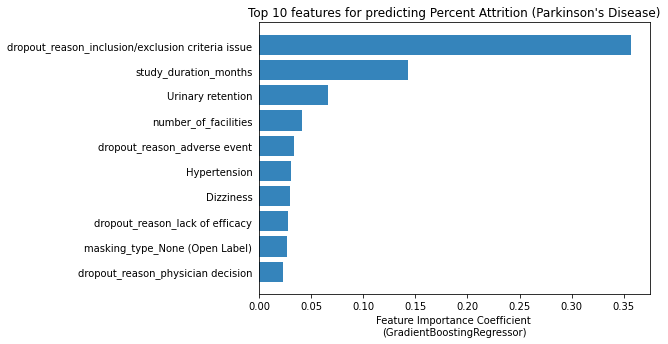

In [ ]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Parkinson's Disease)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('parkinsons_important_features.png')

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

Linear Regression Train R_Square: 1.0
Linear Regression Best Params: {'fit_intercept': False}
Linear Regression Test R_Square: -2.4355626405143025
Linear Regression Best Params: {'fit_intercept': False}
Support Vector Regressor Train R_Square: 0.773958606003159
Support Vector Regressor Best Params: {'C': 1000.0, 'epsilon': 4, 'gamma': 0.01, 'kernel': 'rbf'}
Support Vector Regressor Test R_Square: -0.27983916960626143
Support Vector Regressor Best Params: {'C': 1000.0, 'epsilon': 4, 'gamma': 0.01, 'kernel': 'rbf'}
Random Forest Regressor Train R_Square: 0.8503914475638645
Random Forest Regressor Best Params: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 100}
Random Forest Regressor Test R_Square: 0.4215252061432112
Random Forest Regressor Best Params: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 150}
Decision Tree Regressor Train R_Square: 0.3099706628345902
Decision Tree Regressor Best Params: {'criterion': 'squared_error', 'max_depth': 6, 'max_leaf_nodes': 100, 

[0.0, 100.0]

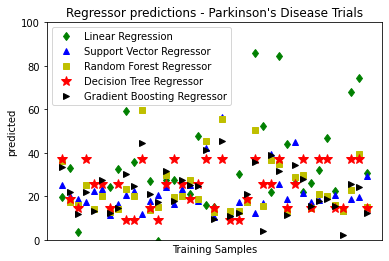

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Parkinson's Disease Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Master 

### Subset Master Studies / Split into test and train sets

In [ ]:
#split into features and outcome dataframes
X_df = V4_master_df.drop(columns=['percent_attrition', 'disease_type', 'intervention_model_type_Sequential Assignment'])

y_df = V4_master_df.percent_attrition

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((640, 2010), (160, 2010))

In [ ]:
X_df = X_df.loc[:, (X_df != 0).any(axis=0)]
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,0,0,1,0,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,0


### Colinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X_df, thresh=4.0):
    variables = list(range(X_df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_df.iloc[:, variables].values, ix)
               for ix in range(X_df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X_df.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X_df.columns[variables])
    return X_df.iloc[:, variables]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,1,0,0,1,0,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,1,0,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0,0


### Corelated Feature Drop

In [ ]:
df_corr = X_df.corr()
df_corr.head()

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Not Reported,masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
dropout_reason_adverse event,1.000000,0.241159,0.247470,0.506430,0.378847,0.426010,0.193515,0.493697,0.590873,0.015188,...,0.006793,-0.033173,-0.032918,0.059376,0.058112,-0.101457,0.031059,0.064146,-0.063154,-0.017771
dropout_reason_consent withdrawn,0.241159,1.000000,0.081087,0.310453,0.086490,0.115868,-0.006455,0.168437,-0.046482,-0.003456,...,0.013981,0.013054,-0.025358,-0.029537,0.053218,-0.037200,-0.015078,-0.003165,-0.032211,0.062652
dropout_reason_death,0.247470,0.081087,1.000000,0.228369,0.018147,0.114569,0.236183,0.028040,0.374674,0.087721,...,0.026005,-0.031457,-0.007997,0.024060,0.056774,-0.014566,-0.031492,0.033528,-0.028812,-0.016628
dropout_reason_inclusion/exclusion criteria issue,0.506430,0.310453,0.228369,1.000000,0.146560,0.179957,0.053016,0.106933,0.365794,0.074414,...,0.017235,-0.024001,-0.030071,-0.009944,0.072187,-0.036975,-0.003614,0.017644,-0.033793,0.023828
dropout_reason_lack of efficacy,0.378847,0.086490,0.018147,0.146560,1.000000,0.309769,-0.008737,0.248701,0.263023,-0.012213,...,-0.013438,-0.007317,0.043806,0.012859,0.014162,-0.048064,-0.044471,-0.001511,-0.024662,0.046147


In [ ]:
threshold = 0.9


columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = X_df.columns[columns]
selected_columns
X_df = X_df[selected_columns]

In [ ]:
X_df

,dropout_reason_adverse event,dropout_reason_consent withdrawn,dropout_reason_death,dropout_reason_inclusion/exclusion criteria issue,dropout_reason_lack of efficacy,dropout_reason_lost to follow-up,dropout_reason_physician decision,dropout_reason_protocol violation,dropout_reason_subject withdrawal,Influenza,...,allocation_type_Not Reported,allocation_type_Randomized,masking_type_Double,masking_type_None (Open Label),masking_type_Quadruple,masking_type_Single,masking_type_Triple,study_gender_eligibility_All,study_gender_eligibility_Female,study_gender_eligibility_Male
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
3,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,0,0
796,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,1,0,0,1,0,0
797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,1,0,0
798,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0


Standardize and split data 

In [ ]:
X_df_norm = (X_df-X_df.min())/(X_df.max()-X_df.min())

In [ ]:
# Train/test split:
X_train, X_test, y_train, y_test = train_test_split(X_df_norm, y_df, test_size = 0.2, random_state = 2)

X_train.shape, X_test.shape

((640, 1033), (160, 1033))

In [ ]:
mean(y_df)

25.99101549830037

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns;
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge, Lasso

In [ ]:
#Setting up a pipeline
pipe=make_pipeline(StandardScaler(),SelectKBest(f_regression),Ridge())

In [ ]:
#Looking up parameters that can be passed to the pipeline
pipe.get_params().keys()

In [ ]:
#putting together a parameter grid to search over using grid search
params={
    'selectkbest__k':[1,2,3,4,5,6],
    'ridge__fit_intercept':[True,False],
    'ridge__alpha':[5,10],
    'ridge__solver':[ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag',
'saga']
}
#setting up the grid search
gs=GridSearchCV(pipe,params,n_jobs=-1,cv=5)
#fitting gs to training data
gs.fit(X_train, y_train)

In [ ]:
#building a dataframe from cross-validation data
df_cv_scores=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')
#selecting specific columns to create a view
df_cv_scores[['params','split0_test_score', 'split1_test_score', 'split2_test_score',\
       'split3_test_score', 'split4_test_score', 'mean_test_score',\
       'std_test_score', 'rank_test_score']].head()

#checking the selected permutation of parameters
gs.best_params_

In [ ]:
#checking how well the model does on the holdout-set
gs.score(X_test,y_test)

In [ ]:
#plotting predicted body weights vs actual body weights of penguins
y_preds=gs.predict(X_test)
plt.scatter(y_test,y_preds);

In [ ]:
# GradientBoostingRegressor will be used for feature importance
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_preds = reg_model.predict(X_test)
r2_score(y_test, y_preds)
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting Percent Attrition (Master Neuropsychiatric)")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()

plt.savefig('master_important_features.png')

### Modeling - No Feature Selection (only drop colinear and highly correlated features)

Grid Search

*   Linear Regression
*   Random Forest Regressor
*   Decision Tree Regressor
*   Support Vector Regressor 
*   Gradient Boosting Regressor 



In [ ]:
#chose five models to train the data with to see which performs the best : Linear Regression and Support Vector Regression
pipe_lr = Pipeline([('LR', LinearRegression())])
pipe_svm = Pipeline([('SVM', SVR())])
pipe_rfr = Pipeline([('RFR', RandomForestRegressor())])
pipe_dtr = Pipeline([('DTR', DecisionTreeRegressor())])
pipe_gbr = Pipeline([('DTR', GradientBoostingRegressor())])

#create GridSearch parameters

#creates lists to pass into the grid below
C = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
epsilon = [0, 0.01, 0.1, 0.5, 1, 2, 4, 5]
n_estimators = [50,100,150, 200, 300, 500,1000, 1500]
n_jobs = np.array([1, 10, 100, 290, 500])
bootstrap = [True, False]
max_depth = [3,4,6,8,10]
min_samples_split = [10,20,40]
max_depth = [2, 6, 8]
min_samples_leaf = [20, 40, 100]
max_leaf_nodes = [5, 20, 100]
learning_rate = [0.01,0.02,0.03,0.04]
subsample = [0.9, 0.5, 0.2, 0.1]

#these will be passed to the GridSearchCV function below -> which will take a pipeline model and test out each paramter value passed through in the following parameter list
lr_space = [{'fit_intercept':[True, False]}]

svr_space = [{'kernel': ['linear'], 'C' : C, 'epsilon' : epsilon},
         {'kernel': ['rbf'], 'C' : C, 'gamma' : C, 'epsilon' : epsilon}]

rfr_space = [{'max_features' : ["auto"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["sqrt"], 'n_estimators' : n_estimators, 'max_depth' : max_depth},
             {'max_features' : ["log2"], 'n_estimators' : n_estimators, 'max_depth' : max_depth}]

dtr_space = [{'criterion': ['squared_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes},
            {'criterion': ['absolute_error'], 'min_samples_split' : min_samples_split, 'max_depth' : max_depth, 'min_samples_leaf' : min_samples_leaf, 'max_leaf_nodes' : max_leaf_nodes}]

gbr_space = [{'learning_rate': learning_rate, 'subsample' : subsample, 'n_estimators' : n_estimators, 'max_depth' : max_depth}]



##use the GridSearchCV function and pass in both the pipeline created above and the grid parameters 

#pass in cv=5 for the gridsearch to perform cross-validation on our training set
#pass score = accuracy for get the accrucay score when the test is performed 
lr_gs = GridSearchCV(LinearRegression(), param_grid = lr_space, scoring = 'r2', cv = 5, n_jobs = -1)
svm_gs = GridSearchCV(SVR(), param_grid = svr_space, scoring = 'r2', cv = 5, n_jobs = -1)
rfr_gs = GridSearchCV(RandomForestRegressor(), param_grid = rfr_space, scoring = 'r2', cv = 5, n_jobs = -1)
dtr_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = dtr_space, scoring = 'r2', cv = 5, n_jobs = -1)
gbr_gs = GridSearchCV(GradientBoostingRegressor(), param_grid = gbr_space, scoring = 'r2', cv = 5, n_jobs = -1)

lr_grids = [lr_gs]

for lr_pipe in lr_grids:
    lr_pipe.fit(X_train,y_train)

svm_grids = [svm_gs]

for svm_pipe in svm_grids:
    svm_pipe.fit(X_train,y_train)

rfr_grids = [rfr_gs]

for rfr_pipe in rfr_grids:
    rfr_pipe.fit(X_train,y_train)

dtr_grids = [dtr_gs]

for dtr_pipe in dtr_grids:
    dtr_pipe.fit(X_train,y_train)

gbr_grids = [gbr_gs]

for gbr_pipe in gbr_grids:
    gbr_pipe.fit(X_train,y_train)

In [ ]:
#first create a dictionary that contains the classifier types to used int eh for loop. 
lr_grid_dict = {0: 'Linear Regression'}

#then create a for loop to train them all 
for i, model in enumerate(lr_grids):
    print('{} Train R_Square: {}'.format(lr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
lr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,lr_y_pred)*100

for i, model in enumerate(lr_grids):
    print('{} Test R_Square: {}'.format(lr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(lr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
svm_grid_dict = {0: 'Support Vector Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(svm_grids):
    print('{} Train R_Square: {}'.format(svm_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
svm_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,svm_y_pred)*100

for i, model in enumerate(svm_grids):
    print('{} Test R_Square: {}'.format(svm_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(svm_grid_dict[i],          results.best_params_))
    
#first create a dictionary that contains the classifier types to used int eh for loop. 
rfr_grid_dict = {0: 'Random Forest Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(rfr_grids):
    print('{} Train R_Square: {}'.format(rfr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
rf_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,rf_y_pred)*100

for i, model in enumerate(rfr_grids):
    print('{} Test R_Square: {}'.format(rfr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(rfr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
dtr_grid_dict = {0: 'Decision Tree Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(dtr_grids):
    print('{} Train R_Square: {}'.format(dtr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
dtr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,dtr_y_pred)*100

for i, model in enumerate(dtr_grids):
    print('{} Test R_Square: {}'.format(dtr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(dtr_grid_dict[i],          results.best_params_))
   
#first create a dictionary that contains the classifier types to used int eh for loop. 
gbr_grid_dict = {0: 'Gradient Boosting Regressor'}

#then create a for loop to train them all 
for i, model in enumerate(gbr_grids):
    print('{} Train R_Square: {}'.format(gbr_grid_dict[i],    model.score(X_train,y_train)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          model.best_params_))

results = model.fit(X_train, y_train)
gbr_y_pred=model.predict(X_test)
Accuracy=r2_score(y_test,gbr_y_pred)*100

for i, model in enumerate(gbr_grids):
    print('{} Test R_Square: {}'.format(gbr_grid_dict[i],    results.score(X_test,y_test)))
    print('{} Best Params: {}'.format(gbr_grid_dict[i],          results.best_params_))

In [ ]:
#plot predictions 
plt.figure()
plt.plot(lr_y_pred, "gd", label="Linear Regression")
plt.plot(svm_y_pred, "b^", label="Support Vector Regressor")
plt.plot(rf_y_pred, "ys", label="Random Forest Regressor")
plt.plot(dtr_y_pred, "r*", ms=10, label="Decision Tree Regressor")
plt.plot(gbr_y_pred, "k>", label="Gradient Boosting Regressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("Training Samples")
plt.legend(loc="best")
plt.title("Regressor predictions - Master Neuropsychiatric Trials")
plt.setp(plt.gca(),ylim=(0,100))

## Figures

Violin plot of Distribution of Attrition rates by disease

In [57]:
import pandas as pd
import seaborn as sns

master_disease_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Master Notebooks/master_clean_df.csv", index_col=0)

In [58]:
master_disease_df.groupby('disease_type', as_index=False)['percent_attrition'].mean()

,disease_type,percent_attrition
0,Alzheimer's Disease,29.233883
1,Amyotrophic lateral sclerosis,30.833077
2,Anxiety,19.145636
3,Bipolar,35.917211
4,Depression,23.234011
5,Parkinson's Disease,20.698929


Text(0.5, 1.0, 'Distribution of Percent Attrition')

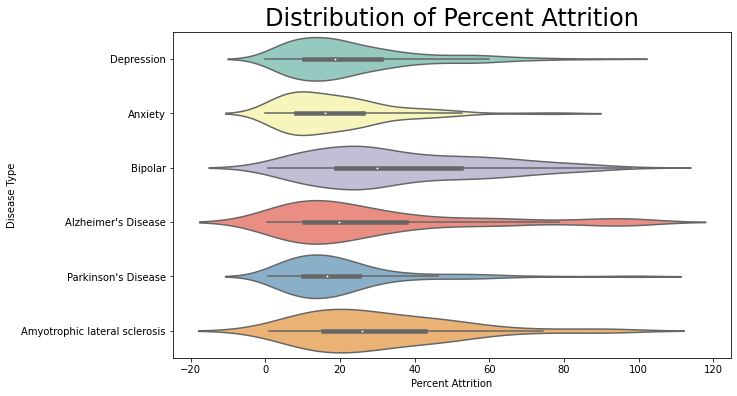

In [17]:
plt.figure(figsize=(10,6))
sns.violinplot(x="percent_attrition", y="disease_type", data=master_disease_df, scale="width", palette="Set3")
plt.xlabel("Percent Attrition")
plt.ylabel("Disease Type")
plt.title("Distribution of Percent Attrition", size=24)


Distribution of drop out reason

In [ ]:
master_dropout_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/master_clean_dropout.csv", index_col=0)

In [ ]:
dropout_master_df = pd.merge(master_disease_df,master_dropout_df, on=['nct_id']) 
dropout_master_df

In [ ]:
dropout_master_df = dropout_master_df.rename(columns={"dropout_reason_adverse event": "Adverse Event", "dropout_reason_consent withdrawn": "Consent Withdrawn", "dropout_reason_death": "Death", "dropout_reason_inclusion/exclusion criteria issue": "Inclusion/Exclusion Criteria Issue", "dropout_reason_lack of efficacy": "Lack of Efficacy", "dropout_reason_lost to follow-up": "Lost to Follow-Up", "dropout_reason_physician decision": "Physician Decision", "dropout_reason_protocol violation": "Protocol Violation", "dropout_reason_subject withdrawal": "Subject Withdrawal", "disease_type_y": "disease_type"})

In [ ]:
dropout_df = dropout_master_df[["percent_attrition", "disease_type","Adverse Event","Consent Withdrawn", "Death", "Inclusion/Exclusion Criteria Issue", "Lack of Efficacy", "Lost to Follow-Up", "Physician Decision", "Protocol Violation","Subject Withdrawal"]]

In [ ]:
dropout_df.to_csv('/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/dropout_df.csv')

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Adverse Event", y="percent_attrition", hue="disease_type", data=dropout_df, palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Adverse Events", size=24)
plt.ylim(0,)
plt.xlim(1,)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Consent Withdrawn", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Consent Withdrawal", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Death", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Death", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Inclusion/Exclusion Criteria Issue", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Inclusion/Exclusion Criteria Issue", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Lack of Efficacy", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Lack of Efficacy", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Lost to Follow-Up", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Lost to Follow-Up", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Physician Decision", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Physician Decision", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Protocol Violation", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Protocol Violation", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Subject Withdrawal", y="percent_attrition", hue="disease_type", data=dropout_df,palette="Set3")
plt.ylabel("Percent Attrition")
plt.title("Subject Totals : Subject Withdrawal", size=24)
plt.ylim(0,)
plt.xlim(1,350)

plt.savefig("distribution_adverse_event.png")

In [ ]:

# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import math

Important Features 

In [ ]:
#import AACT files - all diseases
master_disease_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Master Notebooks/master_clean_df.csv", index_col=0)
master_ae_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/Master Notebooks/master_ae.csv")
master_dropout_df = pd.read_csv("/content/drive/MyDrive/HIDS510/Collab Notebooks/NLP Dropout Reason/Dropout Output Files/master_clean_dropout.csv", index_col=0)

In [ ]:
#replave all non zero cells with 1
master_ae_df[master_ae_df != 0] = 1

#add all columns and select the top ten most prevelant
s = master_ae_df.sum()
top_ae_table = master_ae_df[s.sort_values(ascending=False).index[:10]]

#generated list of most prevelant ae
top_ae_table_list = list(top_ae_table.columns)

In [ ]:
top_ae_table_list